# principal component analysis
right now the number of columns is more than double the size of the rows of the dataframe, also, the matrix is extremely sparse, thus, dimensionality reduction is a good step before any further analysis.

updates on v2
- target variable is `total_funding_amount_usd` (originally `female_led`)
- feature engineering for reg!!

In [1]:
# data
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D

# model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import Counter

## data

In [2]:
df = pd.read_csv('../data/feature_engineering/combined_feng_reg.csv', index_col=0)
df.shape

(3000, 5662)

In [3]:
# get data
target_col = 'total_funding_amount_usd'
X = df.drop(columns=target_col)
y = df[target_col]

### data preprocessing

In [4]:
scaling=StandardScaler()
scaling.fit(X)
X_scaled = scaling.transform(X)

## plot evaluation

### plotting principal components

In [5]:
# 2d
def scatter(X, n1=0, n2=1, c_col=target_col):
    plt.scatter(X[:,n1], X[:,n2], c=df[c_col])
    plt.xlabel(f'pc{n1}')
    plt.ylabel(f'pc{n2}')

In [6]:
# 3d
def cube(X, n0=0, n1=1, n2=2, c_col=target_col):
    fig = plt.figure(figsize=(6,6))
    
    # choose projection 3d for creating a 3d graph
    axis = fig.add_subplot(111, projection='3d')
    
    axis.scatter(X[:,n0], X[:,n1], X[:,n2], c=df[c_col])
    axis.set_xlabel(f"pc{n1}", fontsize=10)
    axis.set_ylabel(f"pc{n1}", fontsize=10)
    axis.set_zlabel(f"pc{n2}", fontsize=10)

### plotting explained variance

In [7]:
def bar(pca, n, line=False):
    
    # individual bar plot
    plt.bar(range(1,n+1), pca.explained_variance_ratio_)
    plt.ylabel('Explained Variance (%)')
    plt.xlabel('Components')
    
    # cumulative line plot
    if line==True:
        plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
             np.cumsum(pca.explained_variance_ratio_),
             c='red', label="Cumulative Explained Variance")
        plt.legend(loc='upper left')
        plt.ylabel('Cumulative Explained Variance (%)')

### plotting correlation between principal components and variables

In [8]:
def heatmap(pca, n=20, n1=0, n2=50):
    '''
    n: number of principal components (first n)
    n1: number of variables (starting index)
    n2: number of variables (ending index)
    '''
    
    # set layout
#     sns.set(rc={'figure.figsize':(20,20)})
#     sns.set(font_scale=2)
    
    # plot
    ax = sns.heatmap(pca.components_[:n,n1:n2],
                     cmap='YlGnBu', cbar=False,
                     yticklabels=np.arange(1,n+1),
                     xticklabels=list(X.columns[n1:n2]))
    ax.set_aspect("equal")

In [9]:
def biplot(X_pca, coeff, labels=None):
    xs = X_pca[:,0]
    ys = X_pca[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max()-xs.min())
    scaley = 1.0/(ys.max()-ys.min())
    plt.scatter(xs*scalex, ys*scaley, s=5)
    
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel(f"PC1")
    plt.ylabel(f"PC2")

## machine learning

### n=3

In [10]:
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_scaled)

In [11]:
X_pca3.shape

(3000, 3)

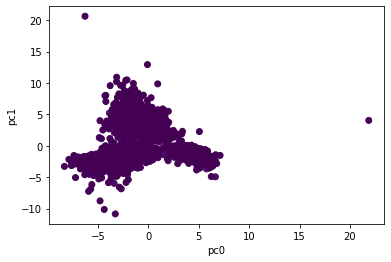

In [12]:
scatter(X_pca3)

In [13]:
# scatter(X_pca3, 0, 2)

In [14]:
# scatter(X_pca3, 1, 2)

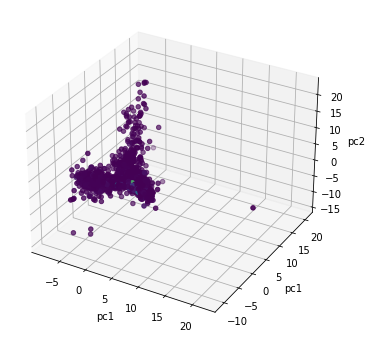

In [15]:
cube(X_pca3)

It seems that 3 components is too little and does not really explain the picture, with the data still very clustered.

### n=3000

default `n_components == min(n_samples, n_features)`

In [22]:
pca = PCA()
X_pca3000 = pca.fit_transform(X_scaled)

In [23]:
X_pca3000.shape

(3000, 3000)

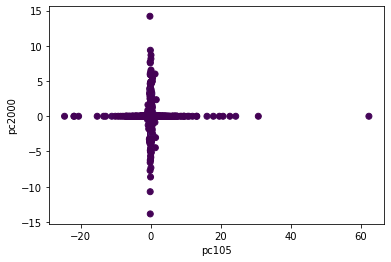

In [24]:
scatter(X_pca3000, 105, 2000)

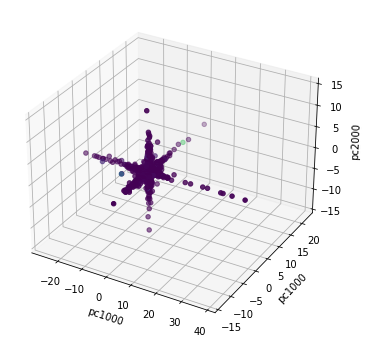

In [25]:
cube(X_pca3000, 100, 1000, 2000)

### deciding on `n`

In [26]:
default_n = 3000

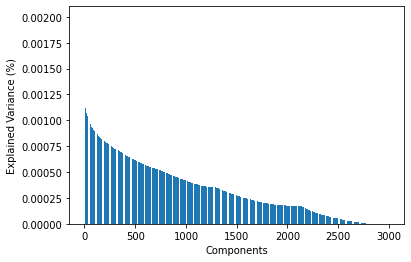

In [27]:
bar(pca, 3000)

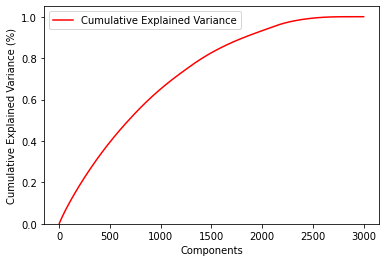

In [28]:
bar(pca, 3000, line=True)

## Interpretation

### 1. Scree Plot
    
In the first bar chart ("**scree plot**"), we can decide on n (`n_components`) depending on where the "elbow" is (i.e. a point at which the proportion of variance explained by each subsequent principal component drops off). 

### 2. Variance Explained Criteria

Another simple approach to decide on the number of principal components is to set a threshold, and stop when the first k components account for a percentage of total variation greater than this threshold (Jolliffe 2002). 

In our case, around **1000** components explain 60% of the data, and somewhere around **1500** explains 80% of the data.

### n=1200

In [29]:
pca1500 = PCA(n_components=1500)
X_pca1500 = pca1500.fit_transform(X_scaled)

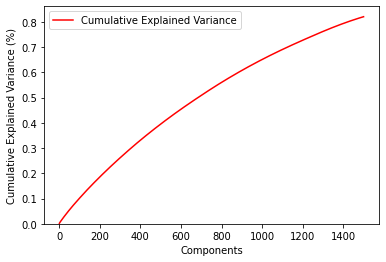

In [30]:
bar(pca1500, 1500, line=True)

### 3. Kaiser-Guttman Rule

The Kaiserâ€™s rule is a widely used method to evaluate the maximum number of linear combinations to extract from the data set. According to that rule, only those principal components whose variances exceed 1 are retained (Jolliffe 2002).

The explained variances are "eigenvalues".  The eigenvalues are sum of squares of the distance between the projected data points and the origin along an eigenvector associated with a principal component.

In [31]:
Counter(pca1500.explained_variance_>1)

Counter({True: 1500})

In [32]:
Counter(pca.explained_variance_>1)

Counter({True: 2125, False: 875})

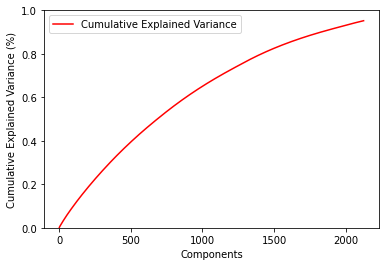

In [33]:
pca2125 = PCA(n_components=2125)
X_pca2125 = pca2125.fit_transform(X_scaled)
bar(pca2125, 2125, line=True)

All 1200 eigenvalues are  greater than 1. When checking all 3000 components, we see that 2125 of them are actually all relatively valuable information.

## Decision
Combining information from the scree plot, cumulative explained variance line plot, and the Kaiser's rule, we should keep 1500 components, keeping 80% of the information.

## Interpreting principal components
### Heatmap

In [34]:
# sns.set(rc={'figure.figsize':(600,200)})
# ax = sns.heatmap(pca1000.components_,
#                  cmap='YlGnBu',
#                  yticklabels=[ "PCA"+str(x) for x in range(1, pca1000.n_components_+1)],
#                  xticklabels=list(X.columns),
#                  cbar_kws={"orientation": "horizontal"})
# ax.set_aspect("equal")

# fig = ax.get_figure()
# fig.savefig('heatmap1000.png')

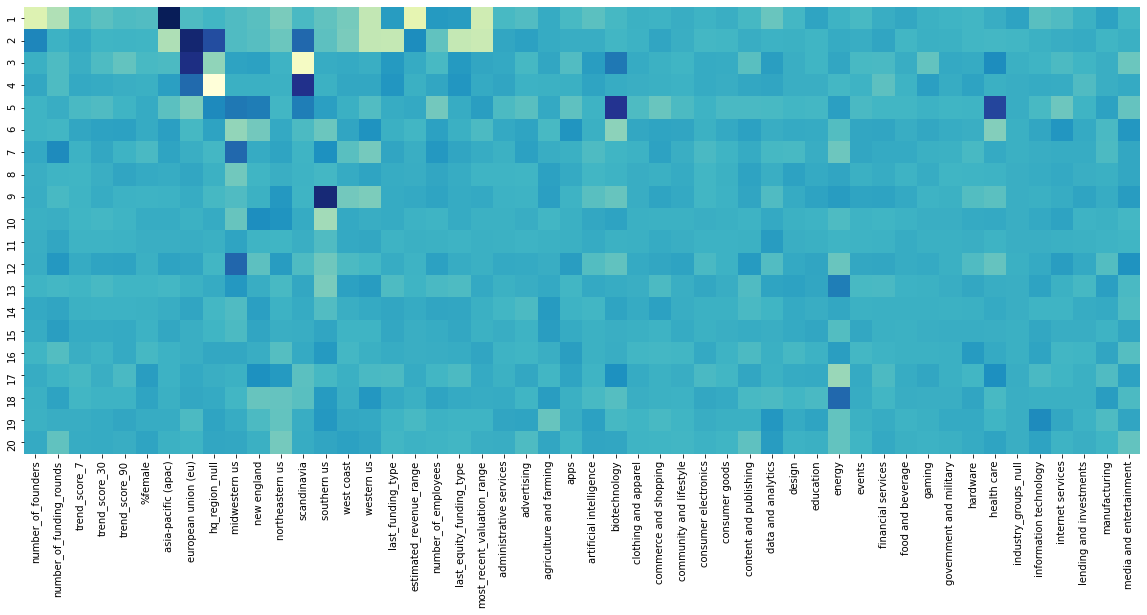

In [36]:
##### sns.set(rc={'figure.figsize':(20,20)})
plt.figure(figsize=(20,15))
# sns.set(font_scale=1)
heatmap(pca2125, n=20, n2=50)
# plt.savefig('heatmap50.png')

write a loop to go through all columns and see its relation with the first 20 of the 1500 components and save those plots

In [37]:
# for i in np.arange(0,7353,50)[:-1]:
#     plt.figure(figsize=(20,15))
#     heatmap(pca1000, n=20, n1=i, n2=i+50)
#     plt.savefig(f'heatmaps/heatmap{i}-{i+50}.png')

In [38]:
# index to remove the last one so that index does not go out of range, 
# can plot the last three variables separately

Instead of plotting all 1500 principal components and all 7353 variables into some thousands of heatmaps, a more systematic way may be to get all the information with absolute correlation greater than a certain threshold.

create a dataframe of correlation between variables and principal components and set corr>1 or corr<-1 and print out the ocrrelation value, the number of pc, and the variable name

In [41]:
# dataframe of explained variance between each pc and features
var_df = pd.DataFrame(pca.components_)

In [47]:
var_df.max().mean()

0.1438945533560485

According to the color bar in the heatmap, the max and min scale annotated are around 0.20 to -0.15, so I thought setting the threshold of the absolute value to 0.15 could be appropriate.

In [48]:
threshold=0.15

In [49]:
high_var = []
for row in range(var_df.shape[0]): #pc
    for col in range(var_df.shape[1]): #var
        if abs(var_df[col].iloc[row]) > threshold:
            high_var.append([row, col, X.columns[col],
                             var_df[col].iloc[row], abs(var_df[col].iloc[row])])

In [50]:
high_var_df = pd.DataFrame(high_var)

In [ ]:
# high_var_df

In [51]:
high_var_df.rename(columns={0: 'principal_component', 1: 'variable', 2: 'variable_name', 
                            3: 'variance', 4: 'variance_abs'}, inplace=True)

In [52]:
high_var_df.shape

(5718, 5)

then get variance in absolute values, look at top 100 values and what variables it corresponds to, **then when fitting back into xgboost model, get the original columns that are selected as top variables in pca instead of fitting in the pc into the model**.

_also try out xgboost native feature importance algorithm_

In [53]:
high_var_df.sort_values('variance_abs', ascending=False)[:10]

principal_component  variable                       variable_name  \
3332                 1982      4222                        qipu capital   
5443                 2850      5644                   cb_rank_(company)   
5444                 2850      5649              cb_rank_(organization)   
5439                 2848      5647                 number_of_investors   
5442                 2849      5651                      monthly_visits   
5438                 2847      5659                     patents_granted   
3341                 1984      4139                   praetura ventures   
5430                 2845      5656                      number_of_apps   
5436                 2847      1717  chongqing industry investment fund   
5441                 2849      3735                     nautic partners   

      variance  variance_abs  
3332  0.845956      0.845956  
5443 -0.708080      0.708080  
5444  0.704699      0.704699  
5439  0.688903      0.688903  
5442 -0.683624      0.683624  
5438  0.609426      0.609426  
3341 -0.600698      0.600698  
5430  0.590842      0.590842  
5436 -0.566765      0.566765  
5441  0.555655      0.555655

In [54]:
high_var_df.sort_values('variance_abs', ascending=False)['variable'].shape

(5718,)

In [55]:
high_var_df.sort_values('variance_abs', ascending=False)['variable'].unique().shape

(2411,)

why would a variable belong to more than one principal component???

In [78]:
high_var_df[high_var_df['variable']==7]

principal_component  variable        variable_name  variance  variance_abs
10                    1         7  european union (eu)  0.220747      0.220747
12                    2         7  european union (eu)  0.198712      0.198712

In [81]:
# high_var_df[high_var_df['variable'].duplicated()==False].to_csv('../data/results_df/important_cols_pca_v2.csv')

In [56]:
high_var_org_col_100 = list(
    high_var_df.sort_values('variance_abs', ascending=False)['variable_name'].unique()[:100])

In [57]:
high_var_org_cols = list(
    high_var_df.sort_values('variance_abs', ascending=False)['variable_name'].unique())

In [58]:
# with open('high_var_org_col_reg.txt', 'w') as writer:
#     writer.write(str(high_var_org_cols))

In [59]:
# with open('high_var_org_col_100_reg.txt', 'w') as writer:
#     writer.write(str(high_var_org_col_100))

didn't use column index anymore because it can cause mistakes as exporting data and getting different col numbers

### understanding each principal components

### PCA Biplot
Biplot contains two plots:

1. PCA scatter plot which shows first two component ( We already plotted this above)
2. PCA loading plot which shows how strongly each characteristic influences a principal component.

**PCA Loading Plot**: All vectors start at origin and their projected values on components explains how much weight they have on that component. Also , angles between individual vectors tells about correlation between them.

In [ ]:
# plt.figure(figsize=(600,600))
# biplot(X_pca1000[:,0:2], np.transpose(pca1000.components_[0:2, :]), list(X.columns))
# plt.savefig('biplot1000.png')

In [ ]:
# def biplot(X_pca, coeff, labels=None):
#     xs = X_pca[:,0]
#     ys = X_pca[:,1]
#     n = coeff.shape[0]
#     scalex = 1.0/(xs.max()-xs.min())
#     scaley = 1.0/(ys.max()-ys.min())
#     plt.scatter(xs*scalex, ys*scaley, s=5)
    
#     for i in range(n):
#         plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
#         if labels is None:
#             plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
#         else:
#             plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
#     plt.xlabel(f"PC1")
#     plt.ylabel(f"PC2")